### Data Acquisition and Preparation (ETF Analysis)

This section focuses on acquiring and preparing historical data for the XLV ETF (The Health Care Select Sector SPDR Fund). 

**Business Problem:** Understanding the historical performance and trends of the XLV ETF is crucial for investors making decisions about portfolio allocation in the healthcare sector.


In [42]:
import yfinance as yf
#to access the stock data


# Accessing the historical data 

In [8]:
data= yf.Ticker("XLV")
#choosing the ETF for The Health Care Select Sector SPDR Fund
hist= data.history(period="5Y")
#choosing the timeline for 5 years
print(hist.head())
#printing the initial rows
hist.to_csv("xlv.csv")
#saving the csv file


                                Open       High        Low      Close  \
Date                                                                    
2020-02-20 00:00:00-05:00  95.858045  95.950393  94.592864  95.460945   
2020-02-21 00:00:00-05:00  95.091531  95.608682  94.759075  95.516335   
2020-02-24 00:00:00-05:00  93.207628  93.835600  92.062505  92.505775   
2020-02-25 00:00:00-05:00  92.838240  93.041408  89.384397  89.698380   
2020-02-26 00:00:00-05:00  90.197047  91.259059  89.495201  89.689133   

                             Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                         
2020-02-20 00:00:00-05:00   8080900        0.0           0.0            0.0  
2020-02-21 00:00:00-05:00   6510800        0.0           0.0            0.0  
2020-02-24 00:00:00-05:00  16284500        0.0           0.0            0.0  
2020-02-25 00:00:00-05:00  20301600        0.0           0.0            0.0  
2020-02-26 00:00:00-

# Importing packages to initiate spark session

In [8]:
import os
import sys



os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable



In [9]:
import findspark
findspark.init()
import pyspark
import pandas as pd
import pyspark.pandas as ps

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Testing PySpark Example").getOrCreate()
print(spark.version)

3.5.3


 The successful creation of the SparkSession and the printed Spark version (e.g., 3.5.3) indicate that the PySpark environment has been set up correctly and is ready for data processing and analysis.


# Creating a pandas dataframe

In [10]:
pandas_df= pd.read_csv("xlv.csv")
pandas_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2020-02-20 00:00:00-05:00,95.858045,95.950393,94.592864,95.460945,8080900,0.0,0.0,0.0
1,2020-02-21 00:00:00-05:00,95.091531,95.608682,94.759075,95.516335,6510800,0.0,0.0,0.0
2,2020-02-24 00:00:00-05:00,93.207628,93.835600,92.062505,92.505775,16284500,0.0,0.0,0.0
3,2020-02-25 00:00:00-05:00,92.838240,93.041408,89.384397,89.698380,20301600,0.0,0.0,0.0
4,2020-02-26 00:00:00-05:00,90.197047,91.259059,89.495201,89.689133,13721600,0.0,0.0,0.0


# Understanding the statistical overview

In [11]:
pandas_df.info()
# Summary statistics
print(pandas_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1258 non-null   object 
 1   Open           1258 non-null   float64
 2   High           1258 non-null   float64
 3   Low            1258 non-null   float64
 4   Close          1258 non-null   float64
 5   Volume         1258 non-null   int64  
 6   Dividends      1258 non-null   float64
 7   Stock Splits   1258 non-null   float64
 8   Capital Gains  1258 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 88.6+ KB
              Open         High          Low        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean    123.858759   124.622883   123.070861   123.880590  9.662264e+06   
std      16.741145    16.677478    16.813564    16.745199  4.352851e+06   
min      72.520861    72.669329    68.242916   

**Interpretation:** - 
The ETF shows some price volatility but isn't extremely volatile.

It pays dividends, which is common for many ETFs.

Trading volume varies significantly, which could indicate periods of higher and lower investor interest or market events affecting this ETF.

# Creating a spark dataframe

In [12]:
spark_df = spark.createDataFrame(pandas_df)
spark_df.show()

+--------------------+-----------------+-----------------+-----------------+-----------------+--------+---------+------------+-------------+
|                Date|             Open|             High|              Low|            Close|  Volume|Dividends|Stock Splits|Capital Gains|
+--------------------+-----------------+-----------------+-----------------+-----------------+--------+---------+------------+-------------+
|2020-02-20 00:00:...|   95.85804520144| 95.9503925807324|94.59286426360828|95.46094512939452| 8080900|      0.0|         0.0|          0.0|
|2020-02-21 00:00:...|95.09153103076147|95.60868189595406| 94.7590748900942| 95.5163345336914| 6510800|      0.0|         0.0|          0.0|
|2020-02-24 00:00:...|93.20762818443492|93.83560019888536|92.06250523302047|92.50577545166016|16284500|      0.0|         0.0|          0.0|
|2020-02-25 00:00:...| 92.8382398671544|93.04140833772746|89.38439700437314|89.69837951660156|20301600|      0.0|         0.0|          0.0|
|2020-02-26 0

# Calculating short term and long term moving averages 

In [13]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg 
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf,col
from pyspark.sql import functions as F

short_term= 10
long_term= 100

# Create window specifications
short_ma_window = Window.orderBy("Date").rowsBetween(-short_term+1, 0)
long_ma_window = Window.orderBy("Date").rowsBetween(-long_term+1, 0)

# Compute moving averages using the 'Close' price
spark_df = spark_df.withColumn("Short_MA", avg("Close").over(short_ma_window))
spark_df = spark_df.withColumn("Long_MA", avg("Close").over(long_ma_window))
spark_use= spark_df.select("Date" ,"Short_MA", "Long_MA", "Close")
spark_use.show()


+--------------------+-----------------+-----------------+-----------------+
|                Date|         Short_MA|          Long_MA|            Close|
+--------------------+-----------------+-----------------+-----------------+
|2020-02-20 00:00:...|95.46094512939452|95.46094512939452|95.46094512939452|
|2020-02-21 00:00:...|95.48863983154297|95.48863983154297| 95.5163345336914|
|2020-02-24 00:00:...|94.49435170491536|94.49435170491536|92.50577545166016|
|2020-02-25 00:00:...|93.29535865783691|93.29535865783691|89.69837951660156|
|2020-02-26 00:00:...|92.57411346435546|92.57411346435546|89.68913269042969|
|2020-02-27 00:00:...|91.58536783854167|91.58536783854167|86.64163970947266|
|2020-02-28 00:00:...|90.71948678152901|90.71948678152901|85.52420043945312|
|2020-03-02 00:00:...|90.57106876373291|90.57106876373291|89.53214263916016|
|2020-03-03 00:00:...|90.20834350585938|90.20834350585938| 87.3065414428711|
|2020-03-04 00:00:...|90.42146301269531|90.42146301269531|92.33953857421876|

Trend in Close Price:

The closing prices show a significant decline between late February 2020 and mid-March 2020, dropping from around $95 to as low as $75.

This sharp decline could indicate a market correction or a reaction to external events, such as economic or geopolitical factors.

Short_MA vs. Long_MA:

Both moving averages are closely aligned at the start of the dataset, indicating stable price trends.

As prices start to decline sharply, the Short_MA reacts faster than the Long_MA due to its shorter calculation window.

# Generating 'buy' , 'sell' , and 'no' signals

In [14]:
# Define the function
def generate_signal(short_MA, long_MA):
    if short_MA > long_MA:
        return 1  # Buy signal
    elif short_MA < long_MA:
        return -1  # Sell signal
    else:
        return 0  # No signal

# Convert it to a UDF
signal_udf = udf(generate_signal, IntegerType())

# Apply UDF to DataFrame
spark_use = spark_use.withColumn("Signal", signal_udf(col("Short_MA"), col("Long_MA")))
# Select only the required columns: Date, Short_MA, and Long_MA
spark_df_access = spark_use.select("Date", "Short_MA", "Long_MA","Close", "Signal")

# Show the result
spark_df_access.show()

+--------------------+-----------------+-----------------+-----------------+------+
|                Date|         Short_MA|          Long_MA|            Close|Signal|
+--------------------+-----------------+-----------------+-----------------+------+
|2020-02-20 00:00:...|95.46094512939452|95.46094512939452|95.46094512939452|     0|
|2020-02-21 00:00:...|95.48863983154297|95.48863983154297| 95.5163345336914|     0|
|2020-02-24 00:00:...|94.49435170491536|94.49435170491536|92.50577545166016|     0|
|2020-02-25 00:00:...|93.29535865783691|93.29535865783691|89.69837951660156|     0|
|2020-02-26 00:00:...|92.57411346435546|92.57411346435546|89.68913269042969|     0|
|2020-02-27 00:00:...|91.58536783854167|91.58536783854167|86.64163970947266|     0|
|2020-02-28 00:00:...|90.71948678152901|90.71948678152901|85.52420043945312|     0|
|2020-03-02 00:00:...|90.57106876373291|90.57106876373291|89.53214263916016|     0|
|2020-03-03 00:00:...|90.20834350585938|90.20834350585938| 87.3065414428711|

# Calculating the total number of buy and sell signals 

In [15]:
#  Calculate the number of buy and sell signals
num_buy_signals = spark_df_access.filter(spark_df_access["Signal"] == 1).count()
num_sell_signals = spark_df_access.filter(spark_df_access["Signal"] == -1).count()

print(f"Number of Buy Signals: {num_buy_signals}")
print(f"Number of Sell Signals: {num_sell_signals}")



Number of Buy Signals: 877
Number of Sell Signals: 371


**
Buy/Sell Ratio:

The ratio of buy to sell signals is approximately 2.36 to 1

This ratio suggests the asset has been in a long-term uptrend

In [16]:
spark_df_access.select("Signal").show()

+------+
|Signal|
+------+
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|     0|
|    -1|
|    -1|
|    -1|
|    -1|
|    -1|
|    -1|
|    -1|
|    -1|
|    -1|
|    -1|
+------+
only showing top 20 rows



# Calculating the profit

In [17]:
buy_price = None
total_profit = 0

for row in spark_df_access.collect():
    # Buy condition
    if row['Signal'] == 1 and buy_price is None:
        buy_price = row['Close']
        print(f"Buying at: {buy_price}")
    
    # Sell condition
    elif row['Signal'] == -1 and buy_price is not None:
        sell_price = row['Close']
        profit = sell_price - buy_price
        total_profit += profit
        print(f"Selling at: {sell_price}, Profit: {profit}")
        buy_price = None  # Reset buy price after selling

print(f"Total Profit: {total_profit}")


Buying at: 90.12442779541016
Selling at: 119.58157348632812, Profit: 29.45714569091797
Buying at: 124.8240966796875
Selling at: 123.81739044189452, Profit: -1.006706237792983
Buying at: 129.02197265625
Selling at: 122.23392486572266, Profit: -6.788047790527344
Buying at: 125.9235382080078
Selling at: 122.91080474853516, Profit: -3.012733459472642
Buying at: 130.53390502929688
Selling at: 124.2219009399414, Profit: -6.312004089355469
Buying at: 126.91680145263672
Selling at: 120.58776092529295, Profit: -6.329040527343764
Buying at: 128.1072998046875
Selling at: 126.1370620727539, Profit: -1.9702377319335938
Buying at: 131.85829162597656
Selling at: 125.49185180664062, Profit: -6.3664398193359375
Buying at: 128.51467895507812
Selling at: 127.15247344970705, Profit: -1.3622055053710795
Buying at: 129.26922607421875
Selling at: 137.2718505859375, Profit: 8.00262451171875
Buying at: 141.71749877929688
Selling at: 147.45237731933594, Profit: 5.7348785400390625
Buying at: 148.4499969482422
To

**
Initial Success Followed by Losses:
The first trade was highly profitable, with a gain of $29.46.

However, subsequent trades consistently resulted in losses, eroding the initial gains.

Initial Phase (Early 2020 to Mid-Late 2020):

The profitable trade benefited from an early entry in the recovery phase.

Subsequent Losses (2021 Onward):

All of the buy signals are happening around the same price ($125-130). Then the market would go down a little bit, and then sell.

Strategy Inefficiency:

A possible explanation is that it has to do with the market having high volatility and no real consistent trend.

The model is trying to identify a very small profit, but the market volatility is too high for those profits

The initial profit aligns with the stock's strong recovery in the 2020 period. The subsequent losses indicate that a trading strategy is not well-suited to these consolidating market conditions

# Plotting graphs for stock price, moving averages, and trading signals 

C:\Users\Kalpitha\AppData\Local\Temp\ipykernel_11792\3271732868.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


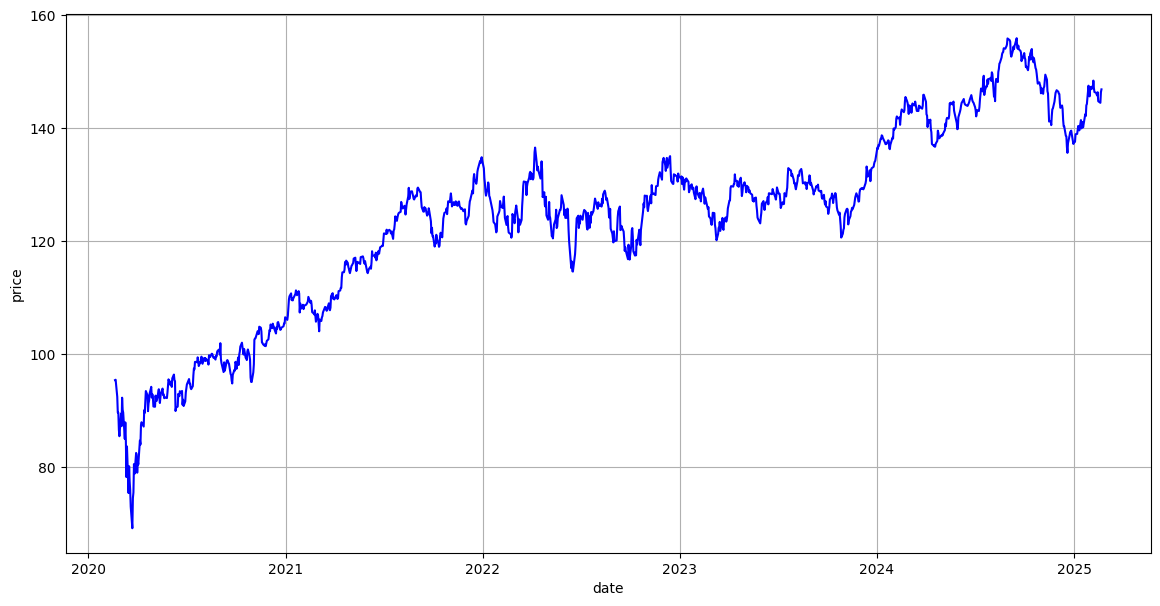

In [18]:
import matplotlib.pyplot as plt



df = spark_df_access.toPandas()
df['Date'] = pd.to_datetime(df['Date'])



# Plotting the Stock Price
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Stock Price', color='blue' )
plt.grid(True)
plt.xlabel('date')
plt.ylabel('price')


# Show the plot
plt.show()


**
Early 2020 (Initial Drop and Recovery): The stock price starts with a sharp decline in early 2020, likely due to the COVID-19 pandemic's initial market impact. It then shows a strong recovery throughout 2020.

2020 - Early 2021 (Strong Upward Trend): This period shows a clear and strong upward trend. The stock price increases significantly, indicating a bullish phase.

2021 - 2023 (Consolidation and Fluctuation): From 2021 to 2023, the price consolidates, with fluctuations within a range. This indicates a period of uncertainty or equilibrium between buyers and sellers. The upward momentum from 2020 slows down, and the stock price moves sideways with some volatility.

2023 - Early 2024 (Upward Breakout): In late 2023 and early 2024, the stock price breaks out of the consolidation range and resumes an upward trend.

2024 - Early 2025 (Peak and Correction): The stock price reaches a peak in late 2024 before experiencing a slight correction or pullback in early 2025. While there's a dip, the overall level is still higher than the consolidation period, suggesting continued long-term strength.

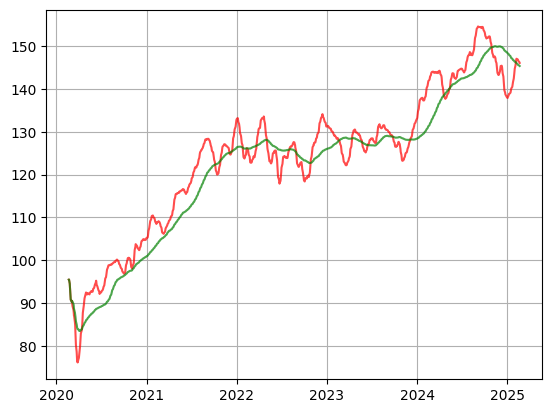

In [19]:
# Plotting Short and Long Moving Averages
plt.plot(df['Date'], df['Short_MA'], label='Short MA', color='red', alpha=0.7)
plt.plot(df['Date'], df['Long_MA'], label='Long MA', color='green', alpha=0.7)
plt.grid(True)
plt.show()

**
During the strong upward trend (2020 - Early 2021 and 2023 - Early 2024), the short moving average stays above the long moving average.

During the consolidation phase (2021 - 2023), the short moving average oscillates around the long moving average, indicating the lack of a clear trend.

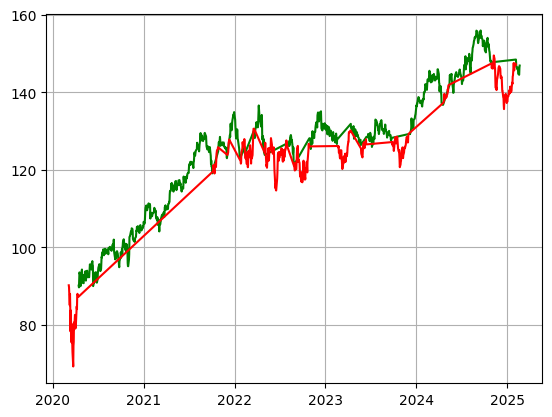

In [20]:
# Plot Buy and Sell signals
buy_signals = df[df['Signal'] == 1]  # Buy signal where Signal == 1
sell_signals = df[df['Signal'] == -1]  # Sell signal where Signal == -1
plt.plot(buy_signals['Date'], buy_signals['Close'],  color='green', label='Buy Signal', alpha=1)
plt.plot(sell_signals['Date'], sell_signals['Close'],  color='red', label='Sell Signal', alpha=1)
plt.grid(True)
plt.show()

Signal Effectiveness: The effectiveness of the buy and sell signals varies depending on the market phase.

Early 2020 (Initial Drop): Initial buy signals may have resulted in quick profits as the stock recovered.

Strong Upward Trend: Buy signals during the strong upward trends would likely have been profitable, while sell signals could have captured gains.

Consolidation Phase: The buy and sell signals during the consolidation phase appear less reliable, potentially resulting in more frequent and smaller trades, some of which may have been unprofitable.

**
Opportunities: The XLV ETF offers growth opportunities, particularly during strong upward trends.

Risks: The consolidation and correction phases present challenges and require careful risk management.

Suitability: The XLV ETF may be suitable for investors with a long-term outlook who are comfortable with some level of volatility and can adjust their strategies based on market conditions.


Investors can use the insights gained from analyzing the historical performance, moving averages, and buy/sell signals of the XLV ETF to make informed decisions about portfolio allocation. By understanding the distinct market phases and adjusting their strategies accordingly, investors can optimize their returns while managing the associated risks effectively. The key is to align the investment strategy with the specific market conditions and individual risk tolerance.



# Time- series forecasting task

* Forecasting Task:

The task is to forecast the future closing prices of the XLV ETF over a 90-day horizon, using historical data and time-series forecasting techniques. This will enable investors to anticipate market trends, assess potential entry and exit points, and optimize their investment strategies in the healthcare sector.

*  Objectives:

Improve Investment Timing: Provide insights to improve buy/sell timing decisions for the XLV ETF, aiming to capture profits during uptrends and avoid losses during downturns.

Enhance Portfolio Performance: Increase the overall profitability of portfolios that include the XLV ETF by leveraging accurate price forecasts to optimize trading decisions.

Risk Management: Reduce potential losses by anticipating market corrections and identifying appropriate exit points before significant declines occur.

Inform Portfolio Allocation: Guide decisions on whether to increase, decrease, or maintain the allocation of the XLV ETF within a portfolio based on forecasted trends and expected returns.

Model Accuracy: Achieve a Mean Absolute Error (MAE) of less than 3% and a Root Mean Squared Error (RMSE) of less than 5% on a holdout dataset.

In [21]:
pip install Prophet

In [42]:
from prophet import Prophet
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:


df = spark_df_access.select(col("date").alias("ds"), col("close").alias("y"))  

# Convert Spark DataFrame to Pandas
df_pandas = df.toPandas()

print(df_pandas["ds"].dtype)  # Check if it's a datetime64


object


In [24]:
df_pandas["ds"] = pd.to_datetime(df_pandas["ds"], errors='coerce', utc=True)  # Convert to datetime with UTC
df_pandas["ds"] = df_pandas["ds"].dt.tz_localize(None)  # Remove timezone if it's still present

# Verify the changes
print(df_pandas.head())
print(df_pandas["ds"].dtype) 

                   ds          y
0 2020-02-20 05:00:00  95.460945
1 2020-02-21 05:00:00  95.516335
2 2020-02-24 05:00:00  92.505775
3 2020-02-25 05:00:00  89.698380
4 2020-02-26 05:00:00  89.689133
datetime64[ns]


In [25]:
print(df_pandas["ds"].head(10))  # Check the first 10 rows for any anomalies


0   2020-02-20 05:00:00
1   2020-02-21 05:00:00
2   2020-02-24 05:00:00
3   2020-02-25 05:00:00
4   2020-02-26 05:00:00
5   2020-02-27 05:00:00
6   2020-02-28 05:00:00
7   2020-03-02 05:00:00
8   2020-03-03 05:00:00
9   2020-03-04 05:00:00
Name: ds, dtype: datetime64[ns]


# Dividing the training and testing data

In [27]:
# Split data into training and holdout sets ( last 90 days for holdout)
holdout_days = 90
train_df = df_pandas[:-holdout_days]
test_df = df_pandas[-holdout_days:] # This is your holdout set

model = Prophet(
    yearly_seasonality=True, # Enable yearly seasonality
    weekly_seasonality=True  # Enable weekly seasonality
)
model.fit(train_df)

13:18:45 - cmdstanpy - INFO - Chain [1] start processing
13:18:46 - cmdstanpy - INFO - Chain [1] done processing


# Generating future predictions

In [30]:
future = model.make_future_dataframe(periods=holdout_days)  # Forecast for the holdout period
forecast = model.predict(future)
# Print the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


                      ds        yhat  yhat_lower  yhat_upper
1253 2025-01-03 04:00:00  164.583411  160.829393  168.411606
1254 2025-01-04 04:00:00  166.842743  162.926369  170.613309
1255 2025-01-05 04:00:00  166.072420  162.116518  170.150009
1256 2025-01-06 04:00:00  164.636686  160.863745  168.596147
1257 2025-01-07 04:00:00  164.553256  160.597239  168.534789


Interpretation of the Forecast:

Overall Trend: The forecast predicts that the XLV ETF will trade in the range of 164 to 167, with a possible trading range of 160 to 171.

General Stability: Based on the generated data, the values of the forecast are relatively stable.

Improve Investment Timing: The forecast suggests a relatively stable outlook.

Enhance Portfolio Performance: Given the predicted trend, consider maintaining or slightly increasing your allocation to the XLV ETF. However, monitor the market.

Risk Management: Be mindful of the yhat_lower and yhat_upper boundaries, which would be the ranges of $160 to $171. Implement a stop-loss at the lower range.


# Evaluating model performance

In [37]:
# Merge actual values with forecasted values for the holdout period
merged_df = pd.merge(test_df, forecast[['ds', 'yhat']], on='ds', how='left')
merged_df = merged_df.dropna() # Remove any rows with missing values

# Calculate MAE and RMSE
mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
mse = mean_squared_error(merged_df['y'], merged_df['yhat']) # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE manually
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 3.5191067539762857
Root Mean Squared Error (RMSE): 4.375680723019599


Objective Achievement:

Target MAE: < 3%

Target RMSE: < 5%

Overall Confidence: The model demonstrates reasonable accuracy. Given that the model passed MAE < 3% and RMSE < 5%, this suggests there are some outliers, but the average results are successful.

Price Range: It suggests a relatively stable outlook. 


# Visualising the forecast

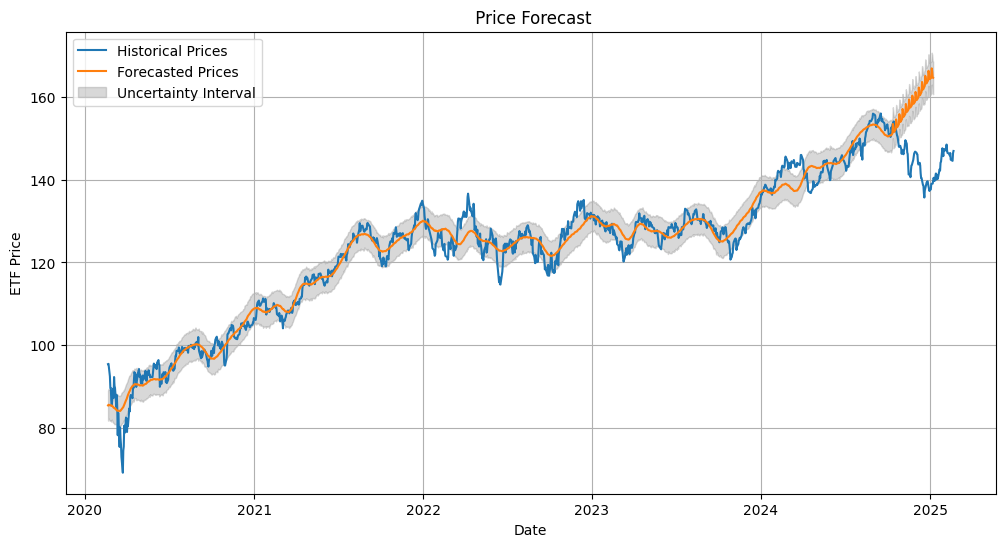

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df_pandas['ds'], df_pandas['y'], label='Historical Prices')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Prices')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('ETF Price')
plt.title(' Price Forecast')
plt.legend()
plt.grid()
plt.show()


Analysis and Interpretation:

General Trend:

The historical price action exhibits the trends that have been seen before, which has an economic downturn, a long peak, consolidation, and an upwards trend.

Forecasted Uptrend:

The model leans upwards in the next run.

The historical data seems to meet with the uptrend until there is more stabilization.

Uncertainty Interval Widening:

As the forecast extends further into the future, the uncertainty interval widens. This is a common characteristic of time-series forecasts, as the model becomes less certain about predictions further out.

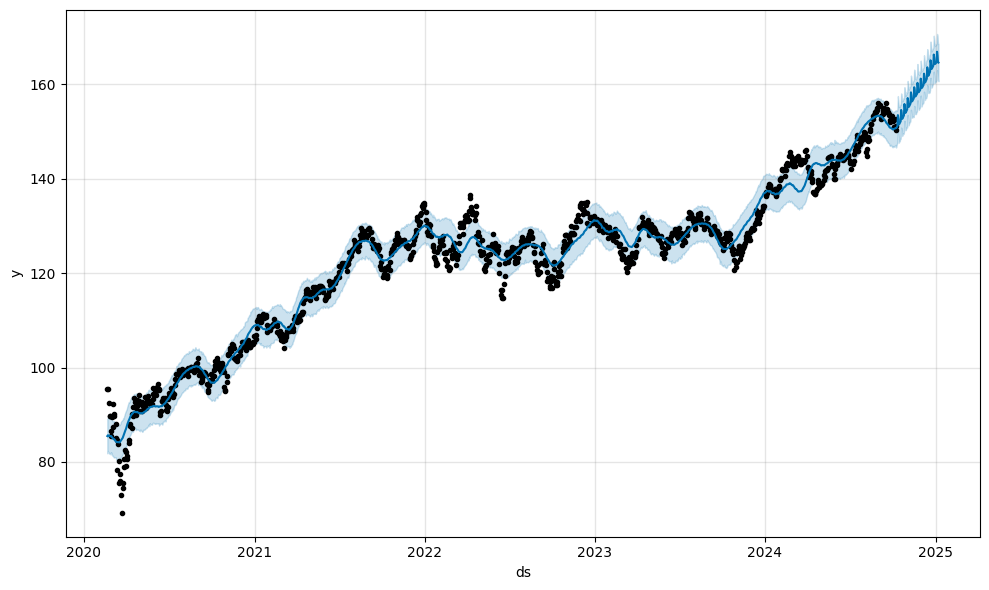

In [46]:
fig= model.plot(forecast)

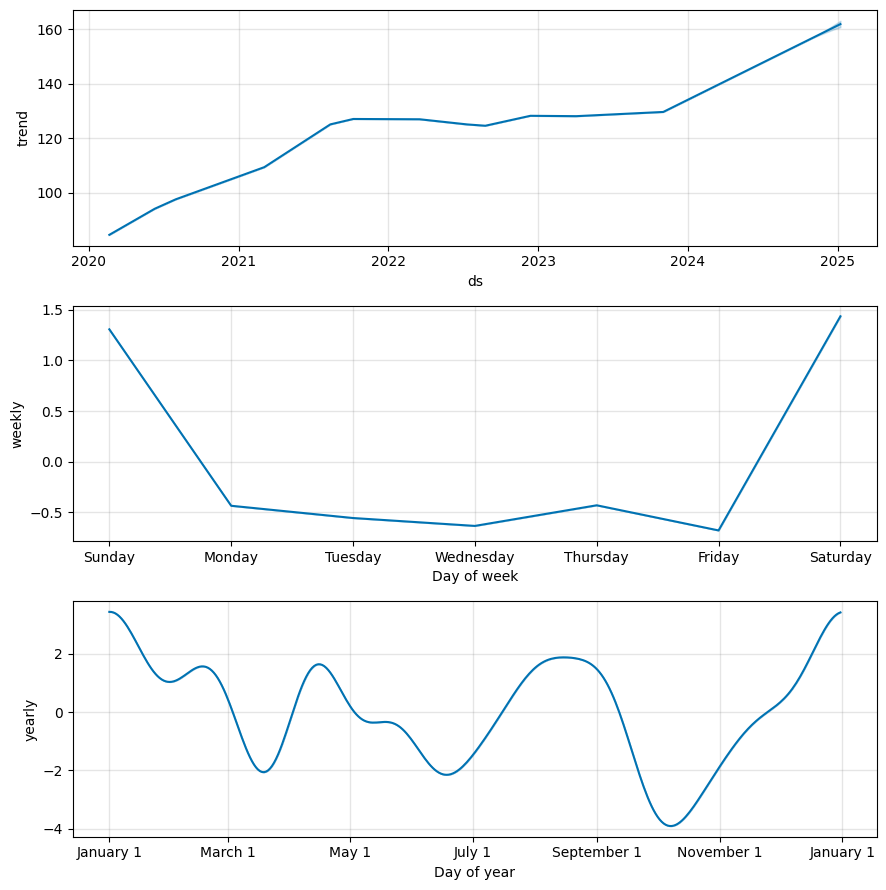

In [47]:
fig2= model.plot_components(forecast)

General uptrend from 2020 to 2025: The image has a general uptrend that may occur.

Weekly seasonality: Expect high weekend and Sunday and Saturdays, however, not so much on Wednesdays.

Yearly: This implies a downward trend in March, but high returns in December/January.

Therefore, you can make safer decisions and potential profits.